## Library

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras.utils as image
import os
import datetime
import numpy as np
import random

## Read in the data

In [2]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/Test1.v1i.folder/train',
  image_size=(128, 128),
  batch_size=32,
  label_mode = "int" 
  )

test_set = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/Test1.v1i.folder/test',
  image_size=(128, 128),
  batch_size=32,
  label_mode = "int" 
  )

valid_set = tf.keras.preprocessing.image_dataset_from_directory(
  'Data/Test1.v1i.folder/valid',
  image_size=(128, 128),
  batch_size=32,
  label_mode = "int" 
  )

Found 1296 files belonging to 2 classes.
Found 62 files belonging to 2 classes.
Found 124 files belonging to 2 classes.


Find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [3]:
class_names = train_set.class_names
print(class_names)

['A', 'S']


Here are the random nine images from the training dataset:

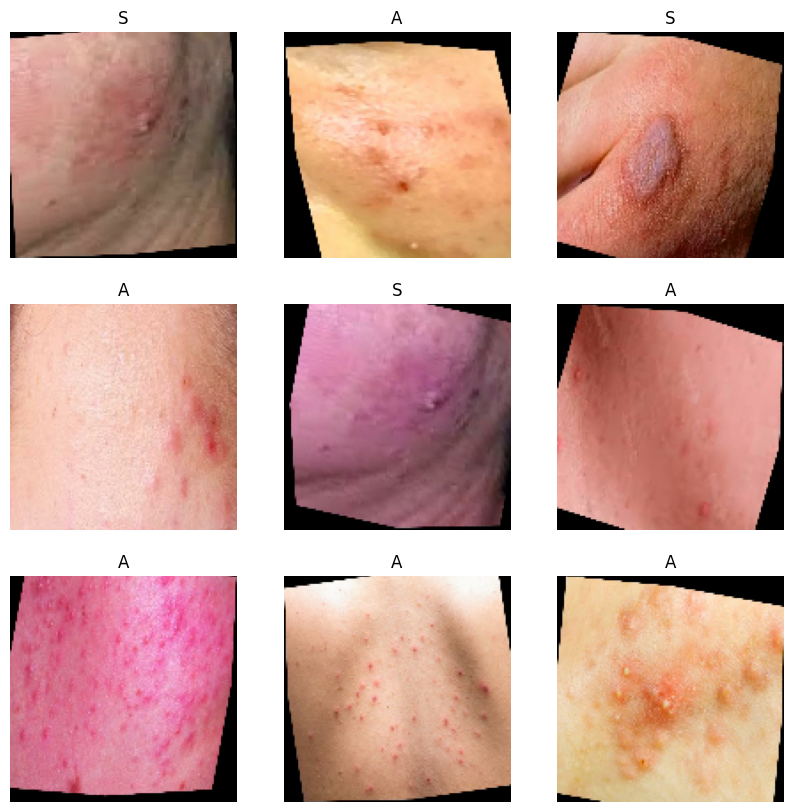

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

According to tf.keras.utils.image_dataset_from_directory document, labels should be sorted according to the alphanumeric order of the image file paths so: 

* Class A : 0

* Class S : 1

In [5]:
#The labels should match the smple images showed above
labels

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0])>

Check number of images for each class.

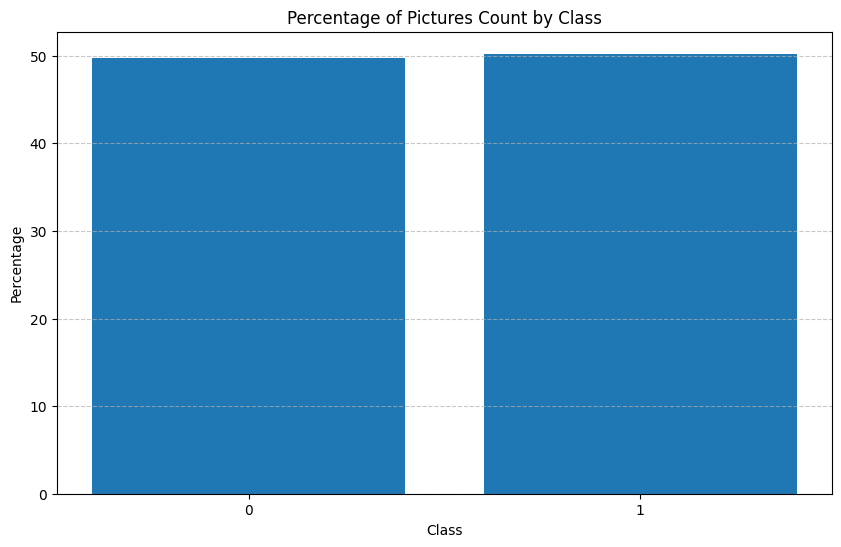

In [6]:
class_count_train = {}
for images, labels in train_set:
    for label in labels.numpy():
        if label not in class_count_train :
            class_count_train [label] = 1
        else:
            class_count_train [label] += 1

class_counts_df_train = {}

for images, labels in train_set:
    for label in labels.numpy():
        class_count_train[label] = class_count_train.get(label, 0) + 1
    
class_counts_df_train = pd.DataFrame(class_count_train .items(), columns=["Class", "Pictures Count"])

total_pictures = class_counts_df_train['Pictures Count'].sum()

# Calculate the percentage for each class and add it as a new column
class_counts_df_train['Percentage'] = (class_counts_df_train['Pictures Count'] / total_pictures) * 100

plt.figure(figsize=(10, 6))
plt.bar(class_counts_df_train['Class'], class_counts_df_train['Percentage'])
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Percentage of Pictures Count by Class')
plt.xticks(class_counts_df_train['Class'])  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

This is a batch of 32 images of shape 128x128x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [7]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


To enhance the performance

* train.cache(): Caches the elements of the dataset, which can improve the training speed by avoiding redundant data loading.

* .shuffle(1000): Shuffles the elements of the dataset with a buffer size of 1000. This randomizes the order of the data, which is beneficial during training.

* .prefetch(buffer_size=AUTOTUNE): Prefetches elements from the dataset to overlap the data loading and model execution. The buffer_size is set to the AUTOTUNE constant, allowing TensorFlow to determine an optimal value for parallelism.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = valid_set.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes = len(class_names)
num_classes

2

## Modeling

Function to plot the learning curve:

In [10]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

## Baseline Model

### cnn1

In [23]:
log_dir = "logs/fit/" + "cnn1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, start_from_epoch=10)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/cnn1_checkpoint", save_best_only=True)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)), # Standardize the data, the pixel values are now in `[0,1]`
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

epochs= 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[tensorboard_callback, early_stopping_callback, checkpoint_callback]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)       

INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


41/41 [==============================] - 7s 148ms/step - loss: 0.7152 - accuracy: 0.5116 - val_loss: 0.6830 - val_accuracy: 0.5726
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.6065

INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


41/41 [==============================] - 6s 142ms/step - loss: 0.6632 - accuracy: 0.6065 - val_loss: 0.6328 - val_accuracy: 0.7339
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 0.5939 - accuracy: 0.6767

INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


41/41 [==============================] - 6s 140ms/step - loss: 0.5939 - accuracy: 0.6767 - val_loss: 0.6029 - val_accuracy: 0.6532
Epoch 4/50
41/41 [==============================] - ETA: 0s - loss: 0.5822 - accuracy: 0.6836

INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


41/41 [==============================] - 6s 137ms/step - loss: 0.5822 - accuracy: 0.6836 - val_loss: 0.5957 - val_accuracy: 0.7097
Epoch 5/50
41/41 [==============================] - 5s 116ms/step - loss: 0.5266 - accuracy: 0.7415 - val_loss: 0.5978 - val_accuracy: 0.6855
Epoch 6/50
41/41 [==============================] - ETA: 0s - loss: 0.5335 - accuracy: 0.7253

INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


41/41 [==============================] - 6s 139ms/step - loss: 0.5335 - accuracy: 0.7253 - val_loss: 0.5598 - val_accuracy: 0.7661
Epoch 7/50
41/41 [==============================] - ETA: 0s - loss: 0.5021 - accuracy: 0.7531

INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


41/41 [==============================] - 6s 136ms/step - loss: 0.5021 - accuracy: 0.7531 - val_loss: 0.5196 - val_accuracy: 0.7581
Epoch 8/50
41/41 [==============================] - 5s 120ms/step - loss: 0.4655 - accuracy: 0.7894 - val_loss: 0.6597 - val_accuracy: 0.5887
Epoch 9/50
41/41 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.7716

INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


41/41 [==============================] - 6s 143ms/step - loss: 0.4725 - accuracy: 0.7716 - val_loss: 0.5161 - val_accuracy: 0.7742
Epoch 10/50
41/41 [==============================] - 5s 125ms/step - loss: 0.4754 - accuracy: 0.7731 - val_loss: 0.5593 - val_accuracy: 0.7177
Epoch 11/50
41/41 [==============================] - 5s 123ms/step - loss: 0.4276 - accuracy: 0.8179 - val_loss: 0.5352 - val_accuracy: 0.7339
Epoch 12/50
41/41 [==============================] - 5s 126ms/step - loss: 0.4614 - accuracy: 0.8056 - val_loss: 0.5337 - val_accuracy: 0.7581
Epoch 13/50
41/41 [==============================] - 5s 123ms/step - loss: 0.4271 - accuracy: 0.8094 - val_loss: 0.5236 - val_accuracy: 0.7500
Epoch 14/50
41/41 [==============================] - 5s 126ms/step - loss: 0.3991 - accuracy: 0.8264 - val_loss: 0.5836 - val_accuracy: 0.6855
Epoch 15/50
41/41 [==============================] - 5s 120ms/step - loss: 0.3974 - accuracy: 0.8210 - val_loss: 0.5546 - val_accuracy: 0.7258
Epoch 16/50

INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn1_checkpoint\assets


41/41 [==============================] - 6s 149ms/step - loss: 0.3116 - accuracy: 0.8688 - val_loss: 0.5124 - val_accuracy: 0.7742
Epoch 21/50
41/41 [==============================] - 5s 126ms/step - loss: 0.2907 - accuracy: 0.8773 - val_loss: 0.5965 - val_accuracy: 0.7016
Epoch 22/50
41/41 [==============================] - 5s 120ms/step - loss: 0.2424 - accuracy: 0.9066 - val_loss: 0.6540 - val_accuracy: 0.7581
Epoch 23/50
41/41 [==============================] - 5s 122ms/step - loss: 0.2482 - accuracy: 0.9043 - val_loss: 0.6782 - val_accuracy: 0.7177
Epoch 24/50
41/41 [==============================] - 5s 130ms/step - loss: 0.2352 - accuracy: 0.8989 - val_loss: 0.6358 - val_accuracy: 0.7661
Epoch 25/50
41/41 [==============================] - 5s 125ms/step - loss: 0.1755 - accuracy: 0.9321 - val_loss: 0.7968 - val_accuracy: 0.7097
Epoch 26/50
41/41 [==============================] - 5s 128ms/step - loss: 0.1533 - accuracy: 0.9437 - val_loss: 0.6000 - val_accuracy: 0.8065
Epoch 27/50

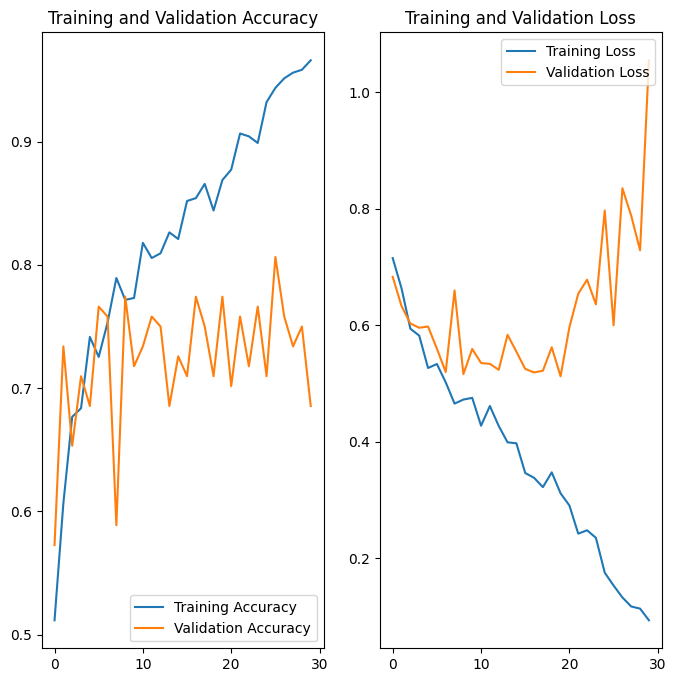

In [25]:
plot_training_history(history)

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 75% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

In [ ]:
model.save("cnn1_model", save_format="tf")

### cnn2

In [14]:
log_dir = "logs/fit/" + "cnn2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=10)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/cnn2_checkpoint", save_best_only=True)

tf.random.set_seed(420)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[tensorboard_callback, early_stopping_callback, checkpoint_callback]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  

INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


41/41 [==============================] - 8s 169ms/step - loss: 0.8151 - accuracy: 0.4830 - val_loss: 0.6931 - val_accuracy: 0.4919
Epoch 2/30
41/41 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5424

INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


41/41 [==============================] - 6s 151ms/step - loss: 0.6926 - accuracy: 0.5424 - val_loss: 0.6923 - val_accuracy: 0.5645
Epoch 3/30
41/41 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5378

INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


41/41 [==============================] - 7s 162ms/step - loss: 0.6903 - accuracy: 0.5378 - val_loss: 0.6910 - val_accuracy: 0.5403
Epoch 4/30
41/41 [==============================] - 6s 135ms/step - loss: 0.6902 - accuracy: 0.5556 - val_loss: 0.6936 - val_accuracy: 0.4919
Epoch 5/30
41/41 [==============================] - ETA: 0s - loss: 0.6815 - accuracy: 0.5579

INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


41/41 [==============================] - 7s 164ms/step - loss: 0.6815 - accuracy: 0.5579 - val_loss: 0.6731 - val_accuracy: 0.5887
Epoch 6/30
41/41 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.6273

INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


41/41 [==============================] - 6s 156ms/step - loss: 0.6517 - accuracy: 0.6273 - val_loss: 0.6425 - val_accuracy: 0.5887
Epoch 7/30
41/41 [==============================] - 6s 135ms/step - loss: 0.6367 - accuracy: 0.6381 - val_loss: 0.6583 - val_accuracy: 0.6210
Epoch 8/30
41/41 [==============================] - 6s 140ms/step - loss: 0.6260 - accuracy: 0.6474 - val_loss: 0.6432 - val_accuracy: 0.5565
Epoch 9/30
41/41 [==============================] - ETA: 0s - loss: 0.5823 - accuracy: 0.6960

INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


41/41 [==============================] - 7s 167ms/step - loss: 0.5823 - accuracy: 0.6960 - val_loss: 0.6125 - val_accuracy: 0.7016
Epoch 10/30
41/41 [==============================] - ETA: 0s - loss: 0.5602 - accuracy: 0.7137

INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


41/41 [==============================] - 7s 161ms/step - loss: 0.5602 - accuracy: 0.7137 - val_loss: 0.6073 - val_accuracy: 0.6694
Epoch 11/30
41/41 [==============================] - ETA: 0s - loss: 0.5574 - accuracy: 0.7230

INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


41/41 [==============================] - 6s 154ms/step - loss: 0.5574 - accuracy: 0.7230 - val_loss: 0.5518 - val_accuracy: 0.7742
Epoch 12/30
41/41 [==============================] - 5s 127ms/step - loss: 0.5631 - accuracy: 0.7083 - val_loss: 0.6310 - val_accuracy: 0.5403
Epoch 13/30
41/41 [==============================] - 5s 120ms/step - loss: 0.5378 - accuracy: 0.7261 - val_loss: 0.5574 - val_accuracy: 0.7258
Epoch 14/30
41/41 [==============================] - ETA: 0s - loss: 0.5220 - accuracy: 0.7407

INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


41/41 [==============================] - 6s 156ms/step - loss: 0.5220 - accuracy: 0.7407 - val_loss: 0.5441 - val_accuracy: 0.7097
Epoch 15/30
41/41 [==============================] - 5s 128ms/step - loss: 0.5195 - accuracy: 0.7485 - val_loss: 0.5863 - val_accuracy: 0.6210
Epoch 16/30
41/41 [==============================] - 5s 126ms/step - loss: 0.4942 - accuracy: 0.7647 - val_loss: 0.5881 - val_accuracy: 0.6371
Epoch 17/30
41/41 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.7531

INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


41/41 [==============================] - 6s 152ms/step - loss: 0.4956 - accuracy: 0.7531 - val_loss: 0.5441 - val_accuracy: 0.7258
Epoch 18/30
41/41 [==============================] - 5s 126ms/step - loss: 0.5056 - accuracy: 0.7454 - val_loss: 0.6195 - val_accuracy: 0.6048
Epoch 19/30
41/41 [==============================] - ETA: 0s - loss: 0.4749 - accuracy: 0.7577

INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


41/41 [==============================] - 6s 156ms/step - loss: 0.4749 - accuracy: 0.7577 - val_loss: 0.5307 - val_accuracy: 0.7419
Epoch 20/30
41/41 [==============================] - 5s 125ms/step - loss: 0.4505 - accuracy: 0.7909 - val_loss: 0.5352 - val_accuracy: 0.7419
Epoch 21/30
41/41 [==============================] - 5s 125ms/step - loss: 0.4743 - accuracy: 0.7731 - val_loss: 0.5554 - val_accuracy: 0.6855
Epoch 22/30
41/41 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.8056

INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn2_checkpoint\assets


41/41 [==============================] - 6s 149ms/step - loss: 0.4287 - accuracy: 0.8056 - val_loss: 0.4921 - val_accuracy: 0.7661
Epoch 23/30
41/41 [==============================] - 5s 119ms/step - loss: 0.4154 - accuracy: 0.7978 - val_loss: 0.5180 - val_accuracy: 0.7661
Epoch 24/30
41/41 [==============================] - 5s 121ms/step - loss: 0.3950 - accuracy: 0.8187 - val_loss: 0.5086 - val_accuracy: 0.7661
Epoch 25/30
41/41 [==============================] - 5s 119ms/step - loss: 0.3908 - accuracy: 0.8279 - val_loss: 0.5549 - val_accuracy: 0.7258
Epoch 26/30
41/41 [==============================] - 5s 121ms/step - loss: 0.3735 - accuracy: 0.8279 - val_loss: 0.5690 - val_accuracy: 0.7177
Epoch 27/30
41/41 [==============================] - 5s 121ms/step - loss: 0.3717 - accuracy: 0.8364 - val_loss: 0.5044 - val_accuracy: 0.7581


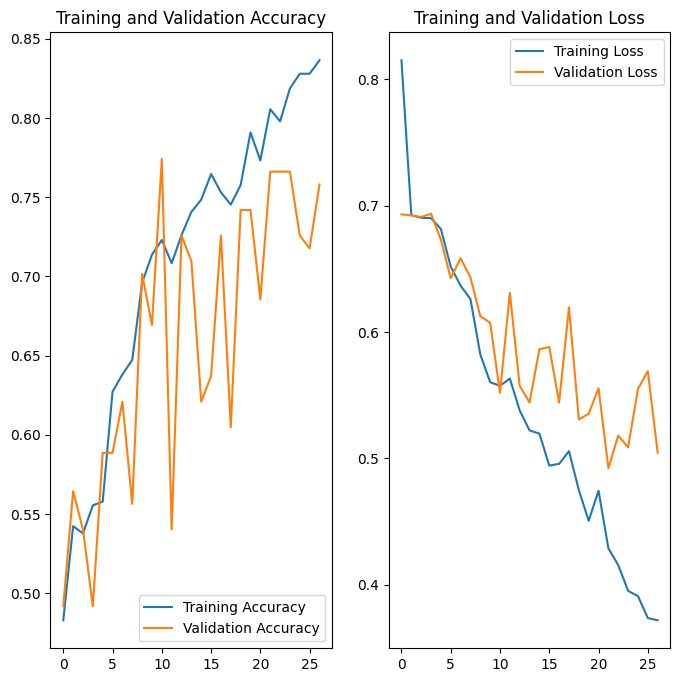

In [15]:
plot_training_history(history)

### cnn3

In [11]:
log_dir = "logs/fit/" + "cnn3"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=10)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/cnn3_checkpoint", save_best_only=True)

tf.random.set_seed(420)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[tensorboard_callback, early_stopping_callback, checkpoint_callback]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4

INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


41/41 [==============================] - 11s 226ms/step - loss: 1.9521 - accuracy: 0.6011 - val_loss: 3.6063 - val_accuracy: 0.5161
Epoch 2/30
41/41 [==============================] - 7s 174ms/step - loss: 0.6032 - accuracy: 0.6883 - val_loss: 5.5890 - val_accuracy: 0.5242
Epoch 3/30
41/41 [==============================] - 7s 173ms/step - loss: 0.5534 - accuracy: 0.7006 - val_loss: 5.4903 - val_accuracy: 0.5403
Epoch 4/30
41/41 [==============================] - 7s 175ms/step - loss: 0.5053 - accuracy: 0.7438 - val_loss: 4.1514 - val_accuracy: 0.5645
Epoch 5/30
41/41 [==============================] - ETA: 0s - loss: 0.4817 - accuracy: 0.7623

INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


41/41 [==============================] - 8s 208ms/step - loss: 0.4817 - accuracy: 0.7623 - val_loss: 3.2459 - val_accuracy: 0.5726
Epoch 6/30
41/41 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.7662

INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


41/41 [==============================] - 9s 210ms/step - loss: 0.4619 - accuracy: 0.7662 - val_loss: 2.5610 - val_accuracy: 0.6452
Epoch 7/30
41/41 [==============================] - ETA: 0s - loss: 0.4406 - accuracy: 0.7816

INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


41/41 [==============================] - 10s 234ms/step - loss: 0.4406 - accuracy: 0.7816 - val_loss: 2.0772 - val_accuracy: 0.6452
Epoch 8/30
41/41 [==============================] - ETA: 0s - loss: 0.3882 - accuracy: 0.8071

INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


41/41 [==============================] - 18s 435ms/step - loss: 0.3882 - accuracy: 0.8071 - val_loss: 1.4306 - val_accuracy: 0.6855
Epoch 9/30
41/41 [==============================] - ETA: 0s - loss: 0.3677 - accuracy: 0.8295

INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


41/41 [==============================] - 17s 422ms/step - loss: 0.3677 - accuracy: 0.8295 - val_loss: 1.1180 - val_accuracy: 0.7097
Epoch 10/30
41/41 [==============================] - 15s 367ms/step - loss: 0.3349 - accuracy: 0.8519 - val_loss: 1.3985 - val_accuracy: 0.6694
Epoch 11/30
41/41 [==============================] - 14s 350ms/step - loss: 0.3320 - accuracy: 0.8488 - val_loss: 1.2561 - val_accuracy: 0.6855
Epoch 12/30
41/41 [==============================] - 11s 275ms/step - loss: 0.2885 - accuracy: 0.8773 - val_loss: 1.9844 - val_accuracy: 0.6935
Epoch 13/30
41/41 [==============================] - 7s 179ms/step - loss: 0.2641 - accuracy: 0.8850 - val_loss: 1.8139 - val_accuracy: 0.6935
Epoch 14/30
41/41 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.8951

INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn3_checkpoint\assets


41/41 [==============================] - 10s 234ms/step - loss: 0.2348 - accuracy: 0.8951 - val_loss: 0.8746 - val_accuracy: 0.6935
Epoch 15/30
41/41 [==============================] - 8s 185ms/step - loss: 0.2018 - accuracy: 0.9136 - val_loss: 1.3123 - val_accuracy: 0.6935
Epoch 16/30
41/41 [==============================] - 8s 184ms/step - loss: 0.1572 - accuracy: 0.9344 - val_loss: 1.1371 - val_accuracy: 0.6371
Epoch 17/30
41/41 [==============================] - 8s 188ms/step - loss: 0.1395 - accuracy: 0.9444 - val_loss: 1.3295 - val_accuracy: 0.7742
Epoch 18/30
41/41 [==============================] - 8s 185ms/step - loss: 0.2379 - accuracy: 0.8958 - val_loss: 1.4537 - val_accuracy: 0.6371
Epoch 19/30
41/41 [==============================] - 8s 185ms/step - loss: 0.2094 - accuracy: 0.9035 - val_loss: 1.6101 - val_accuracy: 0.6855


In [12]:
model.save("cnn3_model", save_format="tf")

INFO:tensorflow:Assets written to: cnn3_model\assets


INFO:tensorflow:Assets written to: cnn3_model\assets


In [13]:
model = tf.keras.models.load_model("cnn3_model")

Continues traing cnn3 for a few more epochs. 

In [14]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  initial_epoch = 19,
  epochs=50, 
  callbacks=[tensorboard_callback, early_stopping_callback, checkpoint_callback]
)

Epoch 20/50


41/41 [==============================] - 9s 190ms/step - loss: 0.2777 - accuracy: 0.8727 - val_loss: 0.9014 - val_accuracy: 0.7500
Epoch 21/50
41/41 [==============================] - 7s 174ms/step - loss: 0.2334 - accuracy: 0.9020 - val_loss: 1.5010 - val_accuracy: 0.6855
Epoch 22/50
41/41 [==============================] - 7s 167ms/step - loss: 0.1877 - accuracy: 0.9221 - val_loss: 1.3948 - val_accuracy: 0.7258
Epoch 23/50
41/41 [==============================] - 7s 173ms/step - loss: 0.1751 - accuracy: 0.9321 - val_loss: 1.2947 - val_accuracy: 0.6774
Epoch 24/50
41/41 [==============================] - 7s 173ms/step - loss: 0.1806 - accuracy: 0.9367 - val_loss: 1.9090 - val_accuracy: 0.6613
Epoch 25/50
41/41 [==============================] - 7s 175ms/step - loss: 0.1536 - accuracy: 0.9329 - val_loss: 1.0769 - val_accuracy: 0.6774


### cnn4

In [11]:
log_dir = "logs/fit/" + "cnn4"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/cnn4_checkpoint", save_best_only=True)
early_stopping_callback_patience20 = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, start_from_epoch= 30)

tf.random.set_seed(420)
model = Sequential([
     layers.Rescaling(1./255, input_shape=(128, 128, 3)),
     layers.Conv2D(16, 3, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
     layers.BatchNormalization(),
     layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.MaxPooling2D(),
     layers.Dropout(0.2),
     layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.MaxPooling2D(),
     layers.Dropout(0.3),
     layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same'),
     layers.BatchNormalization(),
     layers.MaxPooling2D(),
     layers.Dropout(0.4),
     layers.Flatten(),
     layers.Dense(128, activation='relu'),
     layers.BatchNormalization(),
     layers.Dropout(0.5),
     layers.Dense(num_classes, name="outputs")
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[tensorboard_callback, early_stopping_callback_patience20 , checkpoint_callback]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0

INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


41/41 [==============================] - 40s 911ms/step - loss: 0.8563 - accuracy: 0.6350 - val_loss: 2.9099 - val_accuracy: 0.4919
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.6798

INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


41/41 [==============================] - 72s 2s/step - loss: 0.6805 - accuracy: 0.6798 - val_loss: 1.3517 - val_accuracy: 0.5000
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 0.6072 - accuracy: 0.7307

INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


41/41 [==============================] - 73s 2s/step - loss: 0.6072 - accuracy: 0.7307 - val_loss: 0.9880 - val_accuracy: 0.5081
Epoch 4/100
41/41 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.7253

INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


41/41 [==============================] - 73s 2s/step - loss: 0.6149 - accuracy: 0.7253 - val_loss: 0.8414 - val_accuracy: 0.6129
Epoch 5/100
41/41 [==============================] - 66s 2s/step - loss: 0.5622 - accuracy: 0.7454 - val_loss: 0.8582 - val_accuracy: 0.6613
Epoch 6/100
41/41 [==============================] - ETA: 0s - loss: 0.5854 - accuracy: 0.7261

INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


41/41 [==============================] - 72s 2s/step - loss: 0.5854 - accuracy: 0.7261 - val_loss: 0.6134 - val_accuracy: 0.6855
Epoch 7/100
41/41 [==============================] - 65s 2s/step - loss: 0.4793 - accuracy: 0.7739 - val_loss: 0.6766 - val_accuracy: 0.6694
Epoch 8/100
41/41 [==============================] - 65s 2s/step - loss: 0.4352 - accuracy: 0.8117 - val_loss: 0.7139 - val_accuracy: 0.6613
Epoch 9/100
41/41 [==============================] - ETA: 0s - loss: 0.3825 - accuracy: 0.8256

INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


41/41 [==============================] - 72s 2s/step - loss: 0.3825 - accuracy: 0.8256 - val_loss: 0.5626 - val_accuracy: 0.7177
Epoch 10/100
41/41 [==============================] - 66s 2s/step - loss: 0.3924 - accuracy: 0.8333 - val_loss: 0.6630 - val_accuracy: 0.7177
Epoch 11/100
41/41 [==============================] - 67s 2s/step - loss: 0.3436 - accuracy: 0.8480 - val_loss: 0.5753 - val_accuracy: 0.7419
Epoch 12/100
41/41 [==============================] - 67s 2s/step - loss: 0.3193 - accuracy: 0.8611 - val_loss: 0.6350 - val_accuracy: 0.7500
Epoch 13/100
41/41 [==============================] - ETA: 0s - loss: 0.3050 - accuracy: 0.8719

INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


41/41 [==============================] - 73s 2s/step - loss: 0.3050 - accuracy: 0.8719 - val_loss: 0.5009 - val_accuracy: 0.7984
Epoch 14/100
41/41 [==============================] - 66s 2s/step - loss: 0.2873 - accuracy: 0.8812 - val_loss: 0.6177 - val_accuracy: 0.6694
Epoch 15/100
41/41 [==============================] - 66s 2s/step - loss: 0.2525 - accuracy: 0.8974 - val_loss: 0.5622 - val_accuracy: 0.7500
Epoch 16/100
41/41 [==============================] - 66s 2s/step - loss: 0.2300 - accuracy: 0.9074 - val_loss: 0.7705 - val_accuracy: 0.6774
Epoch 17/100
41/41 [==============================] - 66s 2s/step - loss: 0.2205 - accuracy: 0.9035 - val_loss: 0.7219 - val_accuracy: 0.7661
Epoch 18/100
41/41 [==============================] - 66s 2s/step - loss: 0.2509 - accuracy: 0.9020 - val_loss: 0.7679 - val_accuracy: 0.7419
Epoch 19/100
41/41 [==============================] - 66s 2s/step - loss: 0.1867 - accuracy: 0.9290 - val_loss: 0.5166 - val_accuracy: 0.7823
Epoch 20/100
41/41 

INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\cnn4_checkpoint\assets


41/41 [==============================] - 31s 747ms/step - loss: 0.1286 - accuracy: 0.9599 - val_loss: 0.4985 - val_accuracy: 0.7903
Epoch 22/100
41/41 [==============================] - 29s 712ms/step - loss: 0.1342 - accuracy: 0.9529 - val_loss: 0.7183 - val_accuracy: 0.7419
Epoch 23/100
41/41 [==============================] - 29s 712ms/step - loss: 0.1397 - accuracy: 0.9437 - val_loss: 1.2034 - val_accuracy: 0.7097
Epoch 24/100
41/41 [==============================] - 29s 709ms/step - loss: 0.1259 - accuracy: 0.9460 - val_loss: 0.7284 - val_accuracy: 0.7742
Epoch 25/100
41/41 [==============================] - 29s 712ms/step - loss: 0.1231 - accuracy: 0.9483 - val_loss: 0.7288 - val_accuracy: 0.7661
Epoch 26/100
41/41 [==============================] - 29s 720ms/step - loss: 0.1141 - accuracy: 0.9545 - val_loss: 0.8137 - val_accuracy: 0.7581
Epoch 27/100
41/41 [==============================] - 29s 717ms/step - loss: 0.0888 - accuracy: 0.9738 - val_loss: 0.7934 - val_accuracy: 0.782

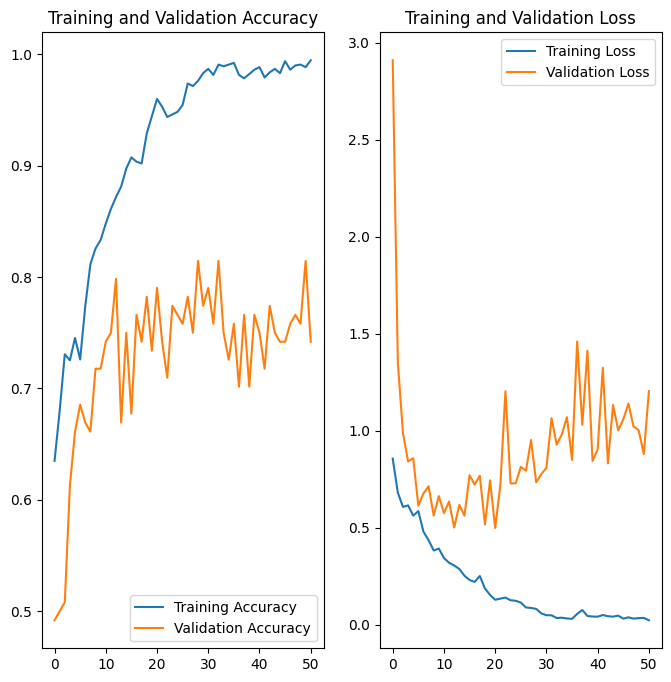

In [12]:
plot_training_history(history)

In [13]:
max(model.history.history["val_accuracy"])

0.8145161271095276

In [14]:
model.save("cnn4_model", save_format="tf")

INFO:tensorflow:Assets written to: cnn4_model\assets


INFO:tensorflow:Assets written to: cnn4_model\assets


## Xception

I load an Xception model, pretrained on ImageNet, and exclude the top of the network by setting include_top=False(This excludes the global average pooling layer and the dense output layer).

All of the trials use transfer learning with following:

Freeze the base model layers train for 5 epochs at 0.1 learning rate then unfreeze the layers for fine-tuning with early stoppping at 0.0001 learning rate.

Optimizar: SGD

Batch Size : 32

In [11]:
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

In [12]:
train_ds = (
    train_ds
    .map(lambda x, y: (preprocess (x), y))
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    val_ds
    .map(lambda x, y: (preprocess (x), y))
    .prefetch(tf.data.AUTOTUNE)
)
test_ds = (
    test_ds
    .map(lambda x, y: (preprocess (x), y))
    .prefetch(tf.data.AUTOTUNE)
)

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [14]:
base_model_xception = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

tf.random.set_seed(42)

#Average Pooling Layer
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model_xception.output)

#Dense Output Layer
output = tf.keras.layers.Dense(num_classes, name="outputs")(avg)

model = tf.keras.Model(inputs = base_model_xception.input, outputs = output)

Freeze the weights of the pretrained layers at the beginning of training.

In [15]:
for layer in base_model_xception.layers:
    layer.trainable = False

In [16]:
log_dir = "logs/fit/" + "xception1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/xception1_checkpoint", save_best_only=True)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

initial_epoch = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=initial_epoch, 
  callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.5245 - accuracy: 0.7971

INFO:tensorflow:Assets written to: checkpoint\xception1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\xception1_checkpoint\assets


41/41 [==============================] - 61s 1s/step - loss: 0.5245 - accuracy: 0.7971 - val_loss: 1.3529 - val_accuracy: 0.6290
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.4127 - accuracy: 0.8735

INFO:tensorflow:Assets written to: checkpoint\xception1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\xception1_checkpoint\assets


41/41 [==============================] - 60s 1s/step - loss: 0.4127 - accuracy: 0.8735 - val_loss: 0.9187 - val_accuracy: 0.8065
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.9059

INFO:tensorflow:Assets written to: checkpoint\xception1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\xception1_checkpoint\assets


41/41 [==============================] - 66s 2s/step - loss: 0.2885 - accuracy: 0.9059 - val_loss: 0.6870 - val_accuracy: 0.8226
Epoch 4/10
41/41 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9336

INFO:tensorflow:Assets written to: checkpoint\xception1_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\xception1_checkpoint\assets


41/41 [==============================] - 57s 1s/step - loss: 0.1574 - accuracy: 0.9336 - val_loss: 0.6034 - val_accuracy: 0.8306
Epoch 5/10
41/41 [==============================] - 47s 1s/step - loss: 0.1423 - accuracy: 0.9406 - val_loss: 0.7074 - val_accuracy: 0.8226
Epoch 6/10
41/41 [==============================] - 47s 1s/step - loss: 0.1843 - accuracy: 0.9298 - val_loss: 0.7623 - val_accuracy: 0.8145
Epoch 7/10
41/41 [==============================] - 45s 1s/step - loss: 0.1100 - accuracy: 0.9606 - val_loss: 0.7791 - val_accuracy: 0.7823
Epoch 8/10
41/41 [==============================] - 44s 1s/step - loss: 0.0865 - accuracy: 0.9676 - val_loss: 0.6830 - val_accuracy: 0.8306
Epoch 9/10
41/41 [==============================] - 45s 1s/step - loss: 0.0729 - accuracy: 0.9753 - val_loss: 0.6291 - val_accuracy: 0.8306
Epoch 10/10
41/41 [==============================] - 45s 1s/step - loss: 0.2744 - accuracy: 0.9059 - val_loss: 0.9824 - val_accuracy: 0.8145


Fine-Tuning

The top layers are now pretty well trained, and I am ready to unfreeze some of the base model’s top layers, then continue training. I will unfreeze layers 116 and above (that’s the start of residual unit 13 out of 14) and use a much lower learning rate

In [17]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model_xception.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [18]:
for layer in base_model_xception.layers[116:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization): #Nornalization layer need to remain frozen
        layer.trainable = True

In [25]:
log_dir = "logs/fit/" + "xception1_finetuning"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("checkpoint/xception1_finetuning_checkpoint", save_best_only=True)
early_stopping_callback_patience20 = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, start_from_epoch= 30)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer= optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fine_tune_epoch = 100
total_epoch =  initial_epoch + fine_tune_epoch

history_finetuning = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=total_epoch, 
  initial_epoch=history.epoch[-1],
  callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback_patience20]
)


Epoch 10/110
41/41 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9738

INFO:tensorflow:Assets written to: checkpoint\xception1_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\xception1_finetuning_checkpoint\assets


41/41 [==============================] - 93s 2s/step - loss: 0.0818 - accuracy: 0.9738 - val_loss: 0.8264 - val_accuracy: 0.8226
Epoch 11/110
41/41 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9853

INFO:tensorflow:Assets written to: checkpoint\xception1_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\xception1_finetuning_checkpoint\assets


41/41 [==============================] - 73s 2s/step - loss: 0.0400 - accuracy: 0.9853 - val_loss: 0.7583 - val_accuracy: 0.8468
Epoch 12/110
41/41 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9931

INFO:tensorflow:Assets written to: checkpoint\xception1_finetuning_checkpoint\assets


INFO:tensorflow:Assets written to: checkpoint\xception1_finetuning_checkpoint\assets


41/41 [==============================] - 65s 2s/step - loss: 0.0271 - accuracy: 0.9931 - val_loss: 0.7502 - val_accuracy: 0.8548
Epoch 13/110
41/41 [==============================] - 57s 1s/step - loss: 0.0230 - accuracy: 0.9969 - val_loss: 0.7534 - val_accuracy: 0.8387
Epoch 14/110
41/41 [==============================] - 55s 1s/step - loss: 0.0199 - accuracy: 0.9992 - val_loss: 0.7571 - val_accuracy: 0.8548
Epoch 15/110
41/41 [==============================] - 55s 1s/step - loss: 0.0169 - accuracy: 0.9992 - val_loss: 0.7635 - val_accuracy: 0.8468
Epoch 16/110
41/41 [==============================] - 55s 1s/step - loss: 0.0151 - accuracy: 0.9992 - val_loss: 0.7688 - val_accuracy: 0.8468
Epoch 17/110
41/41 [==============================] - 55s 1s/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.7741 - val_accuracy: 0.8468
Epoch 18/110
41/41 [==============================] - 55s 1s/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.7802 - val_accuracy: 0.8468
Epoch 19/110
41/41 

In [26]:
max(model.history.history["val_accuracy"])

0.8548387289047241

In [27]:
model.save("xception1_finetuning_model", save_format="tf")

INFO:tensorflow:Assets written to: xception1_finetuning_model\assets


INFO:tensorflow:Assets written to: xception1_finetuning_model\assets
